# fMRI Problem Set 1

The following problem set will require you to (1) load and visualize (f)MRI data in several different ways, (2) create a design matrix capturing the experimental condition, and (3) use regression to model fMRI activity. Each of these problems builds on tools and ideas we've introduced in the in-class demo notebooks. Once you've finished the problem set and all of your answers are displayed below, click *File* > *Export Notebook As...* and select *Export Notebook to HTML*. Open the HTML file in a browser (e.g. Chrome), then save the webpage as a PDF (e.g. using *File* > *Print...* in Chrome on Mac). Check the PDF to make sure your work rendered properly, then submit the PDF to [Gradescope](https://www.gradescope.com/). We'll start by loading in some general-purpose Python modules, but you'll need to load additional modules to complete the problems (look to the demo notebooks for examples). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# add other modules
from nilearn.plotting import (plot_anat, plot_epi, plot_roi, plot_stat_map)
from nilearn.image import (mean_img, index_img)

## Problem 1: Visualization

fMRI datasets are complex and noisy, so it's important to visualize your data at every stage of analysis. We'll begin by loading in the dataset from [Haxby et al., 2001](https://doi.org/10.1126/science.1063736) using [Nilearn](https://nilearn.github.io/) (you'll need to change `data_dir` if you're doing this problem set locally).

In [2]:
from nilearn import datasets

# If you're working on a local machine, change this path
data_dir = '/Users/karenchristianson/Desktop/Princeton/Classes/22Spring/NEU502B/nilearn-data'

# Load the Haxby et al., 2001 data via Nilearn
haxby_dataset = datasets.fetch_haxby(data_dir=data_dir)

For the first set of exercises, we'll visualize (*a*) the T1-weighted anatomical image, (*b*) the EPI image averaged across time, (*c*) an EPI volume at time point 1312, and (*d*) a mask demarcating ventral temporal (VT) cortex.

In [3]:
# choose slice to visualize for the following plots
cut_coords = (0, 0, 30)

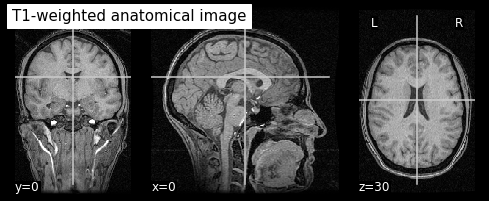

In [4]:
# Visualize the T1-weighted anatomical image here:

plot_anat(haxby_dataset.anat[0], cut_coords=cut_coords,
          vmin = 0, vmax = 200, title = 'T1-weighted anatomical image');

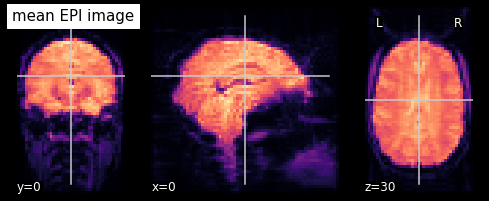

In [5]:
# Visualize the mean EPI image here:

plot_epi(mean_img(haxby_dataset.func[0]), cut_coords=cut_coords,
         cmap='magma', title='mean EPI image');

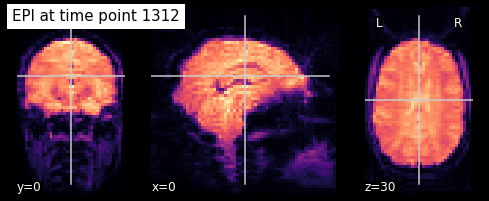

In [6]:
# Visualize EPI volume 1394 here:
# Hint: check out the other nilearn.image functions

# set time point to check out
time_point = 1312

# plot the EPI from time point 1312 (-1 for python indexing)
plot_epi(index_img(haxby_dataset.func[0], time_point-1), cut_coords=cut_coords,
         cmap='magma', title=f'EPI at time point {time_point}');

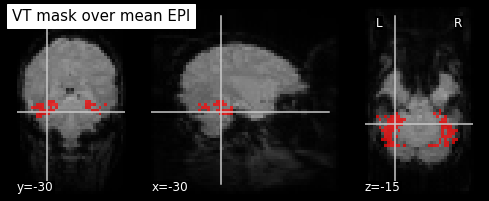

In [7]:
# Visualize the VT mask overlad on the mean EPI here:

# set new coordinates for ROI
cut_coords = (-30, -30, -15)

# plot the VT mask overlaid on mean EPI
plot_roi(roi_img = haxby_dataset.mask_vt[0], 
         bg_img = mean_img(haxby_dataset.func[0]), 
         cut_coords = cut_coords,
         cmap = 'bwr_r', 
         title = 'VT mask over mean EPI');


Next, we'll use [NiBabel](https://nipy.org/nibabel/) to directly load in the data as [NumPy](https://numpy.org/) arrays for manipulation in Python. First, we'll load in the VT mask as a boolean array. Inspect the shape of the functional data and mask, then apply the mask to the functional data to get an array containing EPI time series for only VT cortex. Next, we'll plot the mean time series in VT. Finally, without using Nilearn, create a "carpet plot" via [Power et al., 2017](https://doi.org/10.1016/j.neuroimage.2016.08.009) for VT data where the x-axis corresponds to time and the y-axis corresponds to voxels. Make sure to z-score each voxel's time series prior to plotting (e.g. using `zscore` from `scipy.stats`).

In [8]:
import nibabel as nib

# Use NiBabel to load functional data and VT mask
func_img = nib.load(haxby_dataset.func[0])
func = func_img.get_fdata()
mask_vt = nib.load(haxby_dataset.mask_vt[0]).get_fdata().astype(bool)

# Keep the VT mask voxel indices for later
ids_vt = np.where(mask_vt)

In [9]:
# Inspect shape of functional data and mask here:

print(f'Shape of functional data: {func.shape}')
print(f'Shape of mask: {mask_vt.shape}')

Shape of functional data: (40, 64, 64, 1452)
Shape of mask: (40, 64, 64)


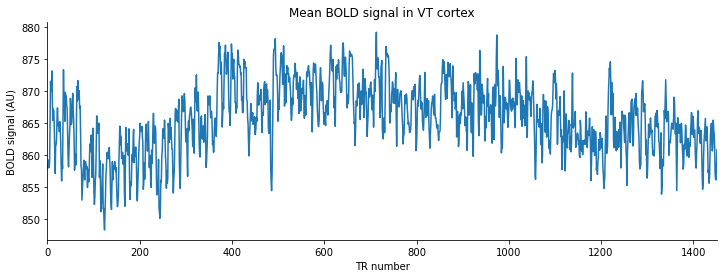

In [10]:
# Plot the mean time series in VT cortex here:

from nilearn.masking import apply_mask

# apply mask to functional data: array of EPI time series for VT voxels only
VT_only = apply_mask(haxby_dataset.func[0], haxby_dataset.mask_vt[0])

# plot mean time series in VT
VT_mean = np.mean(VT_only, axis = 1)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(VT_mean)
ax.margins(x = 0)
ax.set_xlabel('TR number')
ax.set_ylabel('BOLD signal (AU)')
ax.set_title('Mean BOLD signal in VT cortex')
sns.despine()

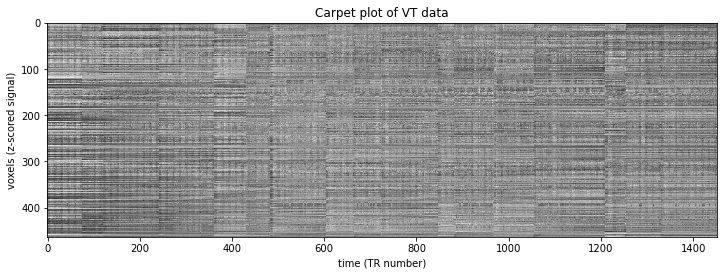

In [11]:
# Plot carpet plot of VT data here:

from scipy.stats import zscore

fig, ax = plt.subplots(figsize = (12, 4))
ax.matshow(zscore(VT_only).T, cmap = 'gray')
ax.set_xlabel('time (TR number)')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('voxels (z-scored signal)')
ax.set_title('Carpet plot of VT data')
plt.show()


## Problem 2: Design

In fMRI analysis, we usually assume that the BOLD signal is the result of a linear time-invariant (LTI) system ([Boynton et al., 1996](http://www.jneurosci.org/content/16/13/4207)); in other words, we assume (1) the shape of the hemodynamic response is constant across time, and (2) the responses to successive stimuli superpose linearly (additively). Assumption #2 justifies using convolution in generating the predicted BOLD signal from a set of stimulus events, $x$, and a hemodynamic response function, $h$. Conceptually, what convolution does is add the entire HRF shape starting wherever there is a non-zero entry.

In the [Haxby et al., 2001](https://doi.org/10.1126/science.1063736) study, participants were presented with images from 8 object categories (bottles, cats, chairs, faces, houses, scissors, scrambled images, and shoes) interspersed with periods of fixation (referred to as "rest" here). The TR in this study was 2.5 seconds. In a given run, a block of images from each of the 8 categories was presented one time. Each block was ~9 TRs long and contained multiple rapid presentations of images from a single category. A subject received 12 scanning runs. For the sake of simplicity, in this example, these runs are concatenated into a single time series 1452 TRs in duration.

In the following exercises, we'll start with the "face" condition. We'll (*a*) create a super-sampled time series of "boxcars" representing blocks of face images, then (*b*) convolve this time series with the SPM HRF, then (*c*) downsample this hypothesized BOLD time series to match the sampling rate (TR) of the fMRI data.

In [12]:
# Image acquition parameters
tr = 2.5
n_trs = 1452

# High-resolution (super-)sampling frequency
sfreq = .1
sst = np.arange(0, n_trs * tr, sfreq)

# Onset/offset timing for face blocks (or "events")
## TR numbers for face blocks
face_blocks = [(21, 29), (127, 135), (248, 256), (426, 434), (490, 498),
               (697, 705), (775, 783), (853, 861), (974, 982),
               (1124, 1132), (1302, 1310), (1394, 1402)]

# High-resolution (super-)sampled face onsets/offsets
## time in seconds for face blocks
face_sst = [(onset * tr, offset * tr)
            for onset, offset in face_blocks]

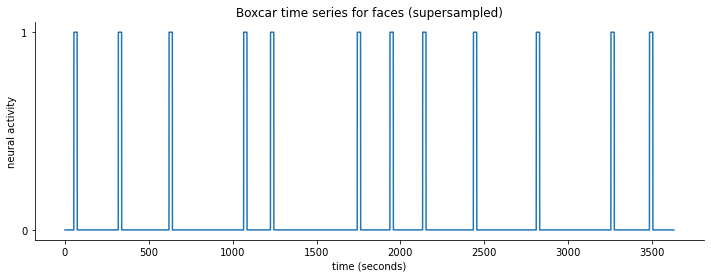

In [13]:
# Generate the boxcar time series for faces and plot here:

# function to generate boxcars from supersampled time series
def generate_boxcars(sst, blocks_sst):
    boxcar_sst = np.zeros(sst.shape)
    for onset, offset in blocks_sst:
        boxcar_sst[np.logical_and(sst >= onset, sst < offset)] = 1
    return boxcar_sst

boxcar_sst = generate_boxcars(sst, face_sst)
    
# plot boxcar supersampled time series
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(sst, boxcar_sst)
ax.set(xlabel = 'time (seconds)', 
       yticks = [0,1], 
       ylabel = 'neural activity',
       title = 'Boxcar time series for faces (supersampled)')
sns.despine()


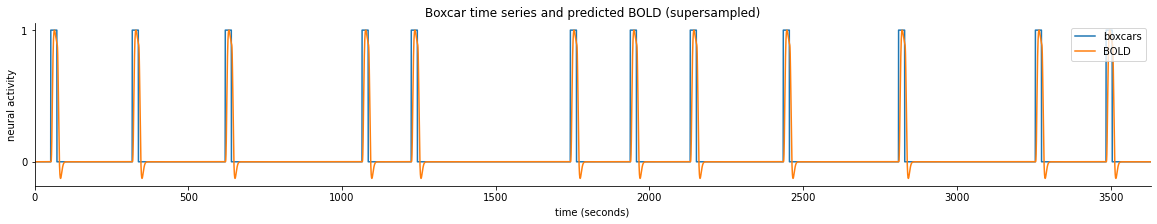

In [14]:
# Convolve the boxcar time series with the SPM HRF and plot here:

# function to define HRF and convolve with boxcars
def convolve_boxcars_hrf(sfreq, boxcar_sst, sst):
    
    # define HRF
    from fmritools.hrf import spm_hrf
    hrf = spm_hrf(sfreq)

    # convolve boxcars with HRF to get predicted BOLD
    bold_sst = np.convolve(boxcar_sst, hrf)[:sst.size]

    # normalize
    bold_sst /= bold_sst.max()
    
    return bold_sst

bold_sst = convolve_boxcars_hrf(sfreq, boxcar_sst, sst)

# plot boxcars and BOLD
fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(sst, boxcar_sst)
ax.plot(sst, bold_sst)
ax.margins(x = 0)
ax.set(xlabel = 'time (seconds)', 
       yticks = [0,1], 
       ylabel = 'neural activity', 
       title = 'Boxcar time series and predicted BOLD (supersampled)')
plt.legend(['boxcars', 'BOLD'], loc = 'upper right')
sns.despine()

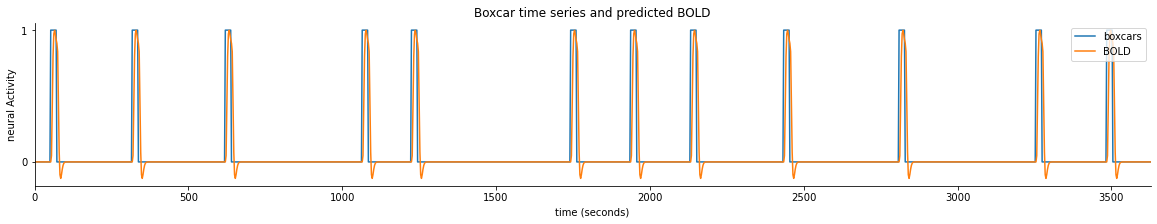

In [15]:
# Downsample and plot both time series here:

# function for downsampling
def downsample(number_trs, tr_length, sst, boxcar_supersampled, bold_supersampled):
    
    # actual TR time series
    actual_ts = np.arange(number_trs) * tr_length

    # define downsampling indices from sst
    downsample_idx = np.isin(sst, actual_ts)

    # downsample boxcars and bold
    boxcar_actual = boxcar_supersampled[downsample_idx]
    bold_actual = bold_supersampled[downsample_idx]
    
    return actual_ts, boxcar_actual, bold_actual
    
actual_ts, boxcar_actual, bold_actual = downsample(n_trs, tr, sst, boxcar_sst, bold_sst)

# Plot downsampled time series
fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(actual_ts, boxcar_actual)
ax.plot(actual_ts, bold_actual)
ax.margins(x = 0)
ax.set(xlabel='time (seconds)', 
       yticks=[0,1], 
       ylabel='neural Activity',
       title = 'Boxcar time series and predicted BOLD')
plt.legend(['boxcars', 'BOLD'], loc = 'upper right')
sns.despine()

Now we'll use the time series of condition labels provided with the dataset to set to programmatically construct a single design matrix containing regressors for all conditions. We'll load in the time series of condition labels as a [pandas](https://pandas.pydata.org/) DataFrame, and extract all 8 category labels. Using code from above, create a loop that goes through each condition label and constructs a boxcar time series convolved with the SPM HRF, then stack these boxcar time series into a single design matrix. We've provided a helper function called `get_blocks` for converting the label time series from the dataset into our familiar onset/offset block structure. Finally, plot the design matrix, keeping in mind that you might need to transpose it or use `np.repeat` to make it more visible.

In [16]:
import pandas as pd

# Load in condition labels (i.e. "targets") as a pandas DataFrame
targets = pd.read_csv(haxby_dataset.session_target[0], sep=' ')

# Get 8 condition labels excluding "rest"
labels = [l for l in np.unique(targets['labels']).tolist()
          if l != 'rest']

In [17]:
# Function for converting targets to familiar block onsets/offsets
def get_blocks(targets, label):
    regressor = np.zeros(len(targets))
    regressor[targets['labels'] == label] = 1
    blocks = [(on + 1, off) for on, off in
              np.split(np.where(np.diff(regressor) != 0)[0], 12)]
    return blocks

# Make sure it returns the same thing as our previous face_blocks variable
assert(get_blocks(targets, 'face') == face_blocks)

In [18]:
# Create a loop that constructs design matrix here:

# initialize design matrix X with intercept (ones)
X_regressors = np.ones(actual_ts.size)

# loop through conditions to generate bold regressors, append to X
for cond in labels:
    
    # get TR blocks for the condition and convert to supersampled times
    cond_blocks = get_blocks(targets, cond)
    cond_sst = [(onset * tr, offset * tr) for onset, offset in cond_blocks]
    
    # generate boxcars for the condition with supersampled time series from above
    cond_boxcar_sst = generate_boxcars(sst, cond_sst)
        
    # convolve boxcars with HRF to get predicted BOLD
    cond_bold_sst = convolve_boxcars_hrf(sfreq, cond_boxcar_sst, sst)
    
    # downsample
    actual_ts, _, cond_bold_actual = downsample(n_trs, tr, sst, cond_boxcar_sst, cond_bold_sst)
    
    X_regressors = np.column_stack([X_regressors, cond_bold_actual])


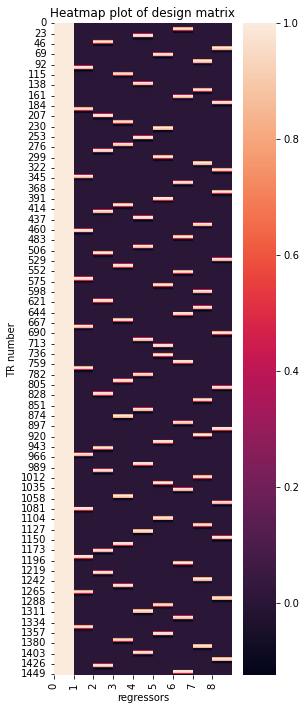

In [19]:
# Plot full design matrix here:

expand_n = 30
fig, ax = plt.subplots(figsize = (4,12))
sns.heatmap(np.repeat(X_regressors, expand_n, axis = 1))
ax.set(xticks = np.arange(0, X_regressors.shape[1]*expand_n, expand_n), 
       xticklabels = np.arange(0, X_regressors.shape[1]), 
       xlabel = 'regressors', 
       ylabel = 'TR number', 
       title = f'Heatmap plot of design matrix')
plt.show()

## Problem 3: Regression

Now that we have a set of predictors (or "regressors") capturing the object categories in our experimental design, we'll use a simple regression analysis to model the fMRI data. The goal is to discover which voxels are most responsive to certain object categories such as faces or houses. First, however, we need to create a set of confound regressors to capture noise in the data — in this case, we'll use detrending polynomials to account for slow signal drifts in each run. The full 1452-TR scan comprises 12 runs, each with 121 TRs. We'll need a 3rd-order polynomial expansion (i.e. a constant vector plus linear, quadratic, and cubic trends) per run. Each run should receive it's own set of detrending variables, with zeros for the other runs, meaning the final confound matrix should be shaped 1452 x 48. Creating this matrix a bit of a chore programming-wise, so we lay most of it out — but you need to fill in the polynomials.

In [20]:
from fmritools import legendre

# Set the runwise polynomial parameters
n_runs = 12
order = 3
run_trs = n_trs // n_runs

# Create a confound matrix with a block of polynomials for each run
confounds = [np.split(run, n_runs, axis=1) for run in
             np.split(np.zeros((n_trs, (order + 1) * n_runs)), n_runs)]
for run in np.arange(n_runs):
    
    confounds[run][run] = legendre(run_trs, order=3) ### Fill in the Legendre polyomials here!!!

confounds = np.block(confounds)

Next, stack this confound matrix alongside our regressors-of-interest to construct the final design matrix (referred to by convention as `X`). Plot this matrix.

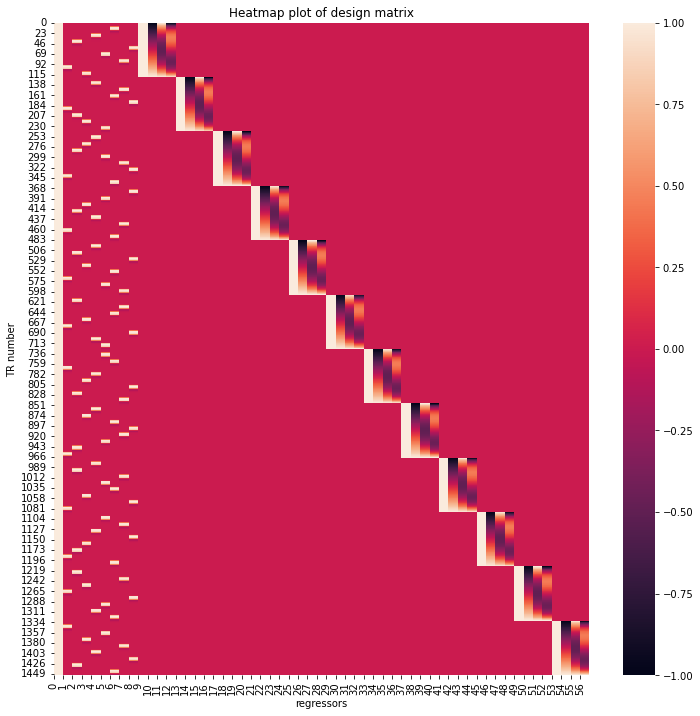

In [21]:
# Stack the regressors-of-interest with the confound matrix and plot here:

# stack regressors and confound matrix
X = np.column_stack([X_regressors, confounds])

# plot the X matrix
expand_n = 10
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(np.repeat(X, expand_n, axis = 1))
ax.set(xticks = np.arange(0, X.shape[1]*expand_n, expand_n), 
       xticklabels = np.arange(0, X.shape[1]), 
       xlabel = 'regressors', 
       ylabel = 'TR number', 
       title = f'Heatmap plot of design matrix')
plt.show()


Now, we'll return to our functional time series in VT cortex from problem 1. This will serve as the `y` variable (i.e. dependent or outcome variable) in our regression model. (Note that you may need to transpose your `X` or `y` arrays to make sure they match along the time dimension). Now, use ordinary least-squares regression to fit the model and estimate the regression coefficients (referred to as "beta" coefficients or `b`). Matrix-multiply the design matrix `X` by the `b` coefficients to created a predicted time series for VT cortex. Visualize the actual mean activity across VT cortex and the mean predicted time series across VT cortex.

In [22]:
# Run the regresssion to get beta coefficients here: 

# set the VT functional times series to y (dependent variable)
y = VT_only.copy()

# check that X and y time dimension are aligned
assert(y.shape[0] == X.shape[0])

# run OLS regression
b, _, _, _ = np.linalg.lstsq(X, y, rcond=-1)


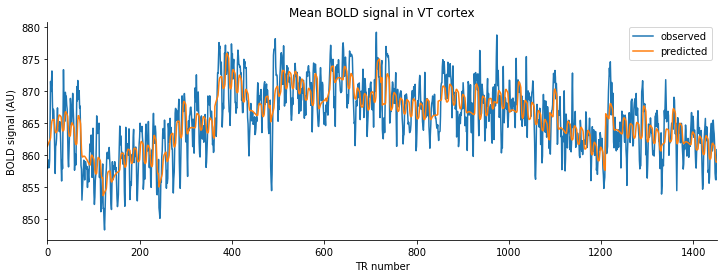

In [23]:
# Compute the predicted time series for VT cortex
# and plot the mean predicted time series alongside
# the actual predicted time series here:

# matrix multiply design matrix X and coefficients b to get predicted time series for VT cortex
y_pred = X @ b

# sanity check
assert(y.shape == y_pred.shape)

# mean predicted activity in VT
y_pred_mean = np.mean(y_pred, axis = 1)

# plot mean actual activity and mean predicted activity in VT
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(VT_mean) # this is the actual activity variable created in part 1
ax.plot(y_pred_mean)
ax.margins(x = 0)
ax.set_xlabel('TR number')
ax.set_ylabel('BOLD signal (AU)')
ax.set_title('Mean BOLD signal in VT cortex')
plt.legend(['observed', 'predicted'], loc = 'upper right')
sns.despine()

Finally, we'll get the beta coefficients for our regressors-of-interest and plot them on the brain. First, preallocate a single volume of zeros matching the shape of our `func` data (i.e. 40, 64, 64). Next, get the `b` values corresponding to the face or house regressor. Then, use the `ids_vt` variable from above, which denotes the voxels in the full volume correspondig to the VT mask, to insert `b` values for VT cortex into the full volume. Use NiBabel's `Nifti1Image` with `func_img.affine` from above to create a NIfTI image, and supply this to one of Nilearn's `plot_stat_map` (using the mean EPI image as the `bg_img`).

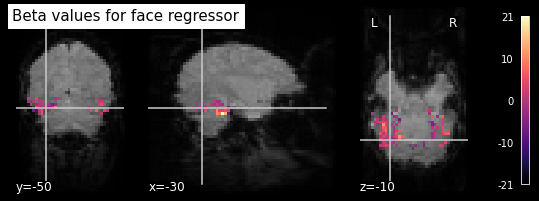

In [24]:
# Plot beta coefficients for the face regressor on the brain here:

# preallocate volume of zeros
face_reg = np.zeros(func.shape[0:3])

# get b values for face regressor
face_index = labels.index('face')
b_face = b[face_index + 1] # +1 because intercept is first column in X

# insert b values for face into the full volume
face_reg[ids_vt] = b_face

# create nifti image
face_img = nib.Nifti1Image(face_reg, affine = func_img.affine)

# plot
plot_stat_map(face_img, bg_img = mean_img(haxby_dataset.func[0]), cut_coords=(-30,-50,-10),
         cmap='magma', title='Beta values for face regressor');

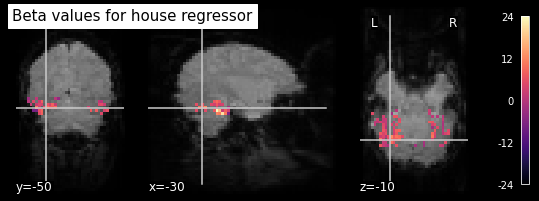

In [25]:
# Plot beta coefficients for the house regressor on the brain here:

# preallocate volume of zeros
house_reg = np.zeros(func.shape[0:3])

# get b values for house regressor
house_index = labels.index('house')
b_house = b[house_index + 1] # +1 because intercept is first column in X

# insert b values for house into the full volume
house_reg[ids_vt] = b_house

# create nifti image
house_img = nib.Nifti1Image(house_reg, affine = func_img.affine) 

# plot
plot_stat_map(house_img, bg_img = mean_img(haxby_dataset.func[0]), cut_coords=(-30,-50,-10),
         cmap='magma', title='Beta values for house regressor');
